# 

In [ ]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

import datetime
import pathlib
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal as sp
import pathlib
import pynapple as nap
import tqdm

import datajoint as dj
from element_interface.utils import find_full_path
import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX
import u19_pipeline.utils.ephys_utils as ephys_utils

from u19_pipeline.ephys_pipeline import ephys_element, probe_element, get_session_directory, get_ephys_root_data_dir

import numpy as np
import u19_pipeline.ephys_pipeline as ep
import u19_pipeline.acquisition as acquisition
from u19_pipeline import recording

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [6]:
key = {'subject_fullname': 'jyanar_ya054', 'session_date': datetime.date(2025, 10, 14)}
key = (acquisition.Session & key).fetch1('KEY')
recording = dj.create_virtual_module('recording', 'u19_recording')
recording_key = ((acquisition.Session * recording.Recording.BehaviorSession) & key).fetch('recording_id', as_dict=True)
session_dir = pathlib.Path(get_session_directory(recording_key[0]))

Read in the OneBox file

In [7]:
session_dir = find_full_path(get_ephys_root_data_dir(),
                            get_session_directory(recording_key))
print(session_dir)
#Check if session is Nidq or OneBox
nidq_session = list(session_dir.glob('*nidq.bin*'))
obx_session = list(session_dir.glob('*obx.bin*'))

if len(nidq_session) == 0 and len(obx_session) == 0:
    print('No session found')
elif len(nidq_session) > 0:
    ephys_session_fullpath = nidq_session[0]
else:
    ephys_session_fullpath = obx_session[0]

#Nidaq file
nidq_meta          = readSGLX.readMeta(ephys_session_fullpath)
nidq_sampling_rate = readSGLX.SampRate(nidq_meta)


# 1: load meta data, and the content of the NIDAQ file. Its content is digital.            
new_trial_channel = 1
new_iteration_channel = 2
# If PXIe card (nidq) card use for recording deduce digital channels
if nidq_meta['typeThis'] == 'nidq':
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta)
# If onebox card (obx) card use for recording digital channels are 0-2
else:
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta, d_line_list=[0,1])
    # If no sync pulse found trial and iteration signals are 0 & 1 respectively
    channel0_pulses = np.where(np.diff(digital_array[0])==1)[0].shape[0]
    channel1_pulses = np.where(np.diff(digital_array[1])==1)[0].shape[0]

    if channel0_pulses > channel1_pulses:
        new_trial_channel = 1
        new_iteration_channel = 0
    else:
        new_trial_channel = 0
        new_iteration_channel = 1

obx_iters_ttl = digital_array[new_iteration_channel,:]
obx_trials_ttl = digital_array[new_trial_channel,:]
obx_trial_start_idx = ephys_utils.get_idx_trial_start(obx_trials_ttl)
clock_time_s = np.arange(0, len(obx_iters_ttl)/nidq_sampling_rate, step=1/nidq_sampling_rate)
obx_trial_start_s = clock_time_s[obx_trial_start_idx]

Z:\Data\Raw\electrophysiology\jyanar\jyanar_ya054\20251014_g0\ya054_20251014_g0
nChan: 4, nFileSamp: 113599667


Read in the behavior file

In [8]:
behavior = dj.create_virtual_module('behavior', 'u19_behavior')
session  = behavior.TowersBlock().Trial & key
virmen_time, virmen_iterstart, virmen_num_iterations = session.fetch('trial_time', 'vi_start', 'iterations')

Compute the synced arrays

In [9]:
iter_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(
    digital_array[new_trial_channel,:],
    digital_array[new_iteration_channel,:],
    nidq_sampling_rate,
    virmen_time.shape[0],
    virmen_time,
    mode=None,
)

mode deduction:  pulse_signal


Read in the spiking data

In [10]:
spikes = nap.load_file('E:/20251014_g0/ya054_20251014_g0/ya054_20251014_g0_imec0/job_id_882/catgt_output/kilosort4/ya054_20251014.nwb')['units']
spks_binned = spikes.count(bin_size=0.05)

Let's construct the `trialnumber_vector_samples` and `framenumber_vector_samples` arrays from scratch.
- For the trialnumber array, we'll use the TTL pulses on trial line.
- For the iteration array, we'll use the behavior-reported timestamps in `virmen_time`, relative to the trial start we got from the TTLs.

In [11]:
trial_index = np.repeat(np.nan, len(clock_time_s))
frame_index = np.repeat(np.nan, len(clock_time_s))

In [12]:
NTRIALS = virmen_time.shape[0]

In [13]:
trial_index

array([nan, nan, nan, ..., nan, nan, nan])

In [14]:
# Fill the trial_index array
obx_trial_stop_idx = []
for itrial in range(NTRIALS):
    trl_start_idx = obx_trial_start_idx[itrial]
    trl_start_s   = obx_trial_start_s[itrial]
    virmen_s = virmen_time[itrial]
    trl_stop_idx = np.where(virmen_s[-1] + trl_start_s <= clock_time_s)[0][0] - 1
    obx_trial_stop_idx.append(trl_stop_idx)
    trial_index[trl_start_idx : trl_stop_idx] = itrial + 1

In [15]:
obx_trial_stop_idx = np.asarray(obx_trial_stop_idx)
obx_trial_stop_s   = clock_time_s[obx_trial_stop_idx]

In [16]:
# Fill the frame_index array
iter_start_idx = []
for itrial in tqdm.tqdm(range(NTRIALS)):
    # Compute the trial start and stop indices
    trl_start_idx = obx_trial_start_idx[itrial]
    trl_stop_idx  = obx_trial_stop_idx[itrial]
    trl_start_s   = obx_trial_start_s[itrial]
    trl_stop_s    = clock_time_s[trl_stop_idx]
    # Now iterate over virmen timestamps, filling in each frame
    NFRAMES = virmen_time[itrial].shape[0]
    iter_start_idx_thistrial = []
    for iframe in range(1, NFRAMES):
        itr_start_s = virmen_time[itrial][iframe - 1] # Relative time to trial start
        itr_stop_s  = virmen_time[itrial][iframe]     # Relative time to trial start
        # Compute the number of frames to get there
        itr_start_idx = int(np.floor(itr_start_s * nidq_sampling_rate))
        itr_stop_idx  = int(np.floor(itr_stop_s * nidq_sampling_rate))
        # Express in absolute time
        itr_start_idx += trl_start_idx
        itr_stop_idx += trl_start_idx
        iter_start_idx_thistrial.append(itr_start_idx)
        # SLOW
        #itr_start_s = trl_start_s + virmen_time[itrial][iframe - 1]  # Express start and stop in absolute time
        #itr_stop_s  = trl_start_s + virmen_time[itrial][iframe]
        #itr_start_idx = np.where(itr_start_s <= clock_time_s)[0][0] - 1
        #itr_stop_idx  = np.where(itr_stop_s  <= clock_time_s)[0][0] - 1
        frame_index[itr_start_idx : itr_stop_idx] = iframe

    last_start_rel = virmen_time[itrial][-1]
    last_start_idx = trl_start_idx + int(np.floor(last_start_rel * nidq_sampling_rate))
    # fill until trial stop (or next trial start)
    frame_index[last_start_idx:trl_stop_idx] = NFRAMES

    iter_start_idx.append(np.asarray(iter_start_idx_thistrial))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 213.16it/s]


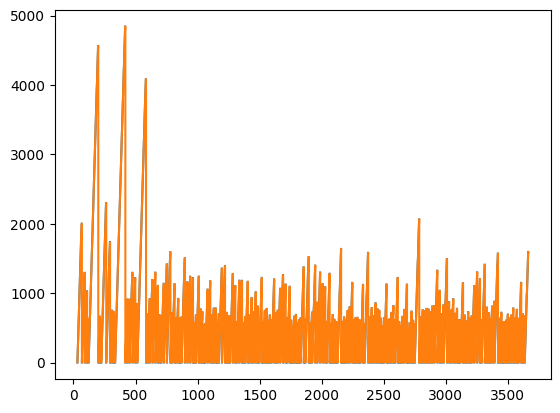

In [17]:
plt.plot(clock_time_s, frame_index)
plt.plot(clock_time_s, iter_dict['framenumber_vector_samples'])

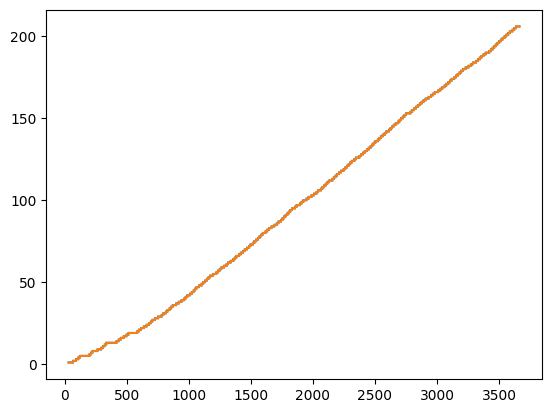

In [18]:
plt.plot(clock_time_s, trial_index)
plt.plot(clock_time_s, iter_dict['trialnumber_vector_samples'])

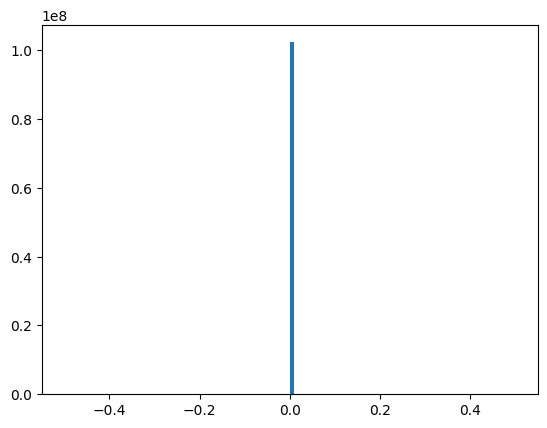

In [24]:
# Are the manually-computed trial_index and frame_index arrays different from what we already had?
plt.hist(np.diff(np.stack((trial_index, iter_dict['trialnumber_vector_samples']), axis=1), axis=1),bins=100);

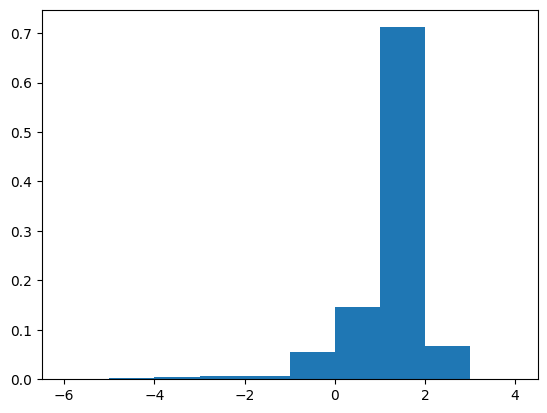

In [29]:
# What about the iteration index?
plt.hist(np.diff(np.stack((frame_index, iter_dict['framenumber_vector_samples']), axis=1), axis=1), density=True);

It looks like the manually computed iteration times can differ from the "borrowed" ones by as much as 6 seconds at times.

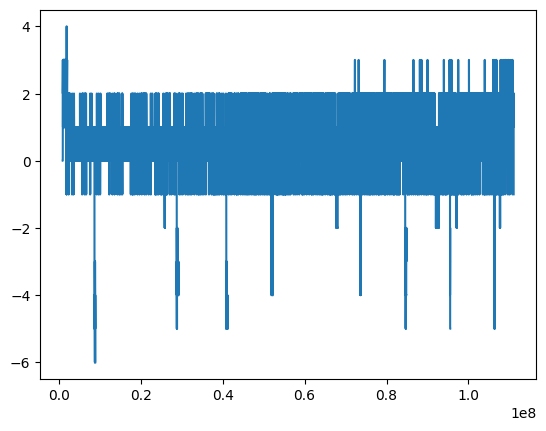

In [27]:
plt.plot(np.diff(np.stack((frame_index, iter_dict['framenumber_vector_samples']), axis=1), axis=1));

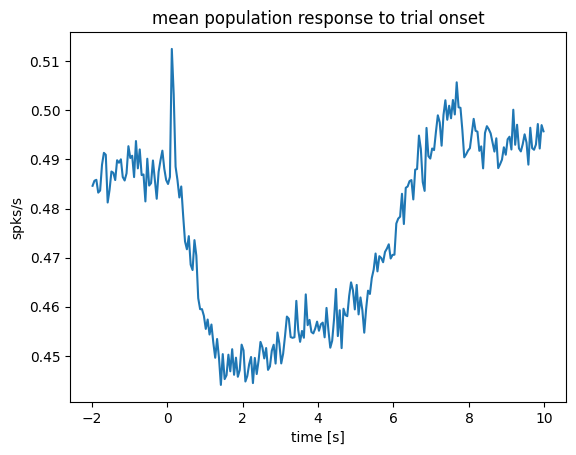

In [39]:
# Sanity check - let's compute the trial-averaged response.
pre_s = 2
post_s = 10
bin_size = 0.05

spk_resp = []
for itrial in range(NTRIALS):
    epoch = nap.IntervalSet(obx_trial_start_s[itrial] - pre_s, obx_trial_start_s[itrial] + post_s)
    spk_resp.append( spikes.restrict(epoch).count(bin_size=bin_size) )

t = spk_resp[0].t - obx_trial_start_s[0] # time axis
spk_resp = np.stack(spk_resp, axis=2)
mean_resp = spk_resp.mean(axis=2).mean(axis=1).T

plt.plot(t, mean_resp)
plt.gca().set(xlabel='time [s]', ylabel='spks/s', title='mean population response to trial onset');

In [53]:
np.savez('ya054_2025-10-14_manual_idx_vecs_v2.npz', 
         trial_index_nidq=trial_index, 
         iteration_index_nidq=frame_index, 
         obx_trial_start_idx=obx_trial_start_idx,
         obx_trial_stop_idx=obx_trial_stop_idx,
         iter_start_idx=np.array(iter_start_idx, dtype='object'),
         sampling_rate=nidq_sampling_rate,
)